In [136]:
import os 
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections import defaultdict

def readFolder(folder, diffExtractor, extraFileFilter=None):
    if extraFileFilter:
        metricFiles = [x for x in os.listdir(folder) if x.endswith(".json") and extraFileFilter(x)]
    else:
        metricFiles = [x for x in os.listdir(folder) if x.endswith(".json")]
    fileToField = dict(zip(metricFiles, [diffExtractor(x) for x in metricFiles]))

    cols = ["tpr_avg", "tpr_std", "f1_avg", "f1_std"]
    dfDict = dict()
    timeDict = dict()
    for file in fileToField:
        with open(os.path.join(folder, file), "r") as f:
            metrics = json.load(f)
        dfDict[fileToField[file]] = pd.DataFrame(columns=cols)
        for fpr in metrics:
            if fpr in ("avg_epoch_time", "epoch_time_avg"):
                timeDict[fileToField[file]] = metrics[fpr]
            else:
                if isinstance(metrics[fpr], dict):
                    tpr_avg = metrics[fpr]["tpr_avg"]
                    tpr_std = np.std(metrics[fpr]["tpr"])
                    f1_avg = metrics[fpr]["f1_avg"]
                    f1_std = np.std(metrics[fpr]["f1"])
                else:
                    arr = np.array(metrics[fpr]).squeeze()
                    if arr.ndim == 1:
                        tpr_avg = arr[0]
                        tpr_std = 0
                        f1_avg = arr[1]
                        f1_std = 0
                    elif arr.ndim == 2:
                        tpr_avg = arr[:, 0].mean()
                        tpr_std = arr[:, 0].std()
                        f1_avg = arr[:, 1].mean()
                        f1_std = arr[:, 1].std()
                dfDict[fileToField[file]].loc[fpr] = [tpr_avg, tpr_std, f1_avg, f1_std]
    return dfDict, timeDict

def plotDict(dfDict, key, ax=None, legendTitle=None, savePath=None):
    if ax is None:
        fig, ax = plt.subplots()
    for diff in dfDict:
        x = dfDict[diff].index.values
        y = dfDict[diff][f"{key}_avg"]
        yerr = dfDict[diff][f"{key}_std"]
        if (yerr > 0).any():
            capsize=10
        else:
            capsize=0
        ax.errorbar(x, y, yerr=yerr, label=diff, marker="o")
    ax.set_xlabel("FPR")
    ax.set_ylabel(f"{key}".upper())
    ax.set_title(f"{key.upper()} vs FPR")
    ax.legend(title=legendTitle)
    # add grid
    ax.grid()
    if savePath:
        plt.tight_layout()
        plt.savefig(savePath)


def plotTrainingTime(timeDict, ax=None, savePath=None, xlabel=""):
    if ax is None:
        fig, ax = plt.subplots()
    if any([x for x in timeDict if "_" in x]):
        x = sorted([x for x in timeDict])
    else:
        x = sorted([int(x) for x in timeDict])
    y = [timeDict[str(value)] for value in x]
    ax.plot(x, y, marker="o")
    ax.set_xlabel(xlabel)
    ax.set_ylabel("Training Time (s)")
    ax.set_title(f"Training Time vs {xlabel}")
    # set y limit to be -10 + 10 of min max y values
    ax.set_ylim(min(y) - 10, max(y) + 10)
    # add grid
    ax.grid()
    if savePath:
        plt.tight_layout()
        plt.savefig(savePath)

def plotFolder(folder, field, diffExtractor, extraFileFilter=None, savePath=None, title=None, figSize=(18, 6)):
    dfDict, timeDict = readFolder(folder, diffExtractor)

    fig, ax = plt.subplots(1, 3, figsize=figSize)
    if title is None:
        title = folder
    plt.suptitle(title, fontsize=16)

    plotDict(dfDict, "tpr", legendTitle=field, ax=ax[0])
    plotDict(dfDict, "f1", legendTitle=field, ax=ax[1])
    plotTrainingTime(timeDict, ax=ax[2], xlabel=field)

    if savePath:
        plt.tight_layout()
        plt.savefig(savePath)

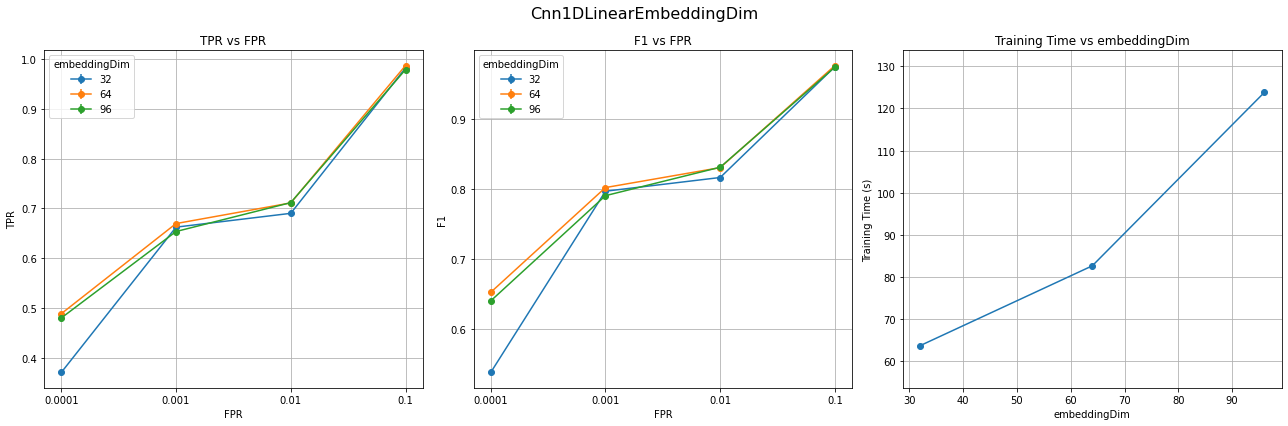

In [132]:
folder = "Cnn1DLinearEmbeddingDim"
field = "embeddingDim"
diffExtractor = lambda x: x.split(field)[1].split("_")[1]

plotFolder(folder, field, diffExtractor, savePath=f"{folder}.png")

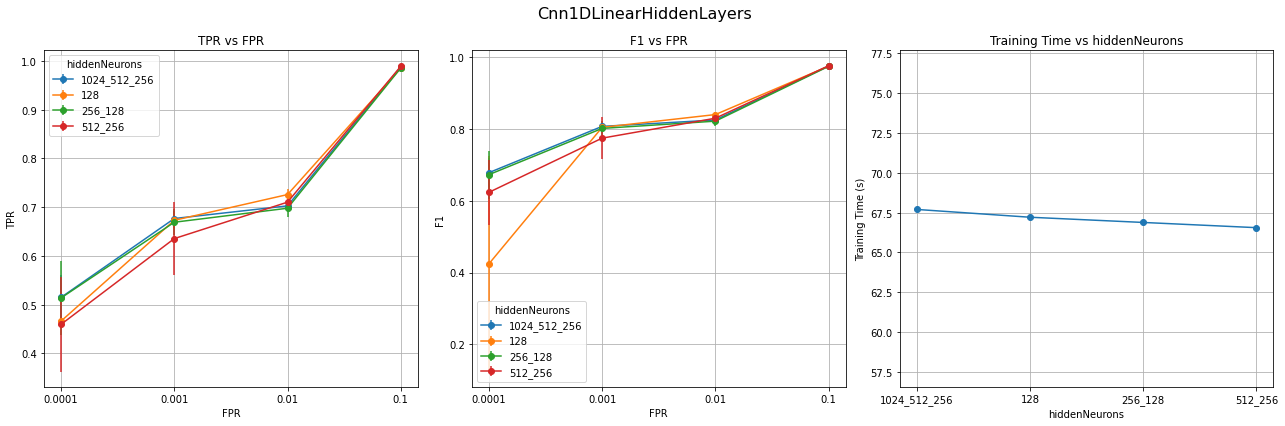

In [133]:
folder = "Cnn1DLinearHiddenLayers"
field = "hiddenNeurons"
diffExtractor = lambda x: x.split(field)[1].split("batch")[0].strip("_")

plotFolder(folder, field, diffExtractor, savePath=f"{folder}.png")

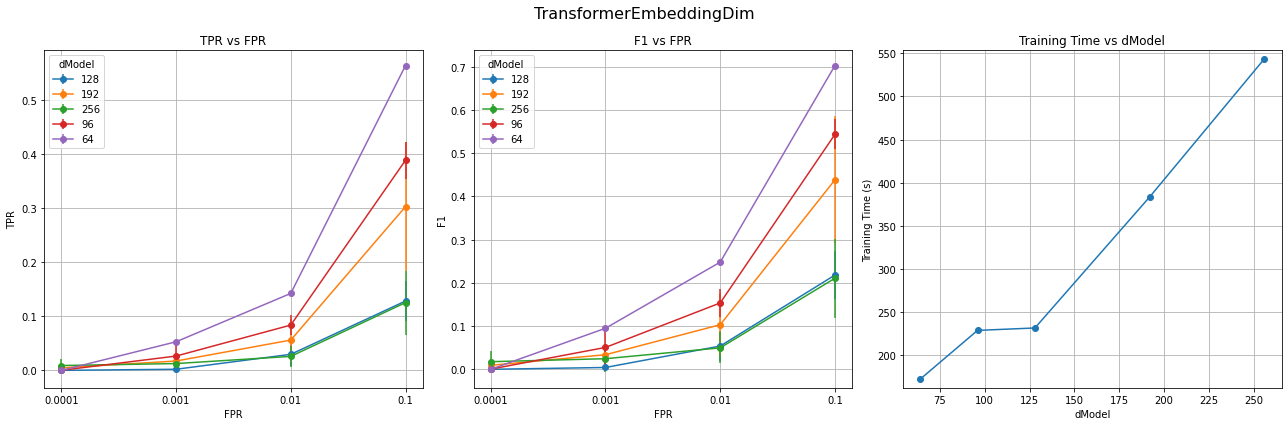

In [134]:
folder = "TransformerEmbeddingDim"
field = "dModel"
diffExtractor = lambda x: x.split(field)[1].split("_")[1]

plotFolder(folder, field, diffExtractor, savePath=f"{folder}.png")

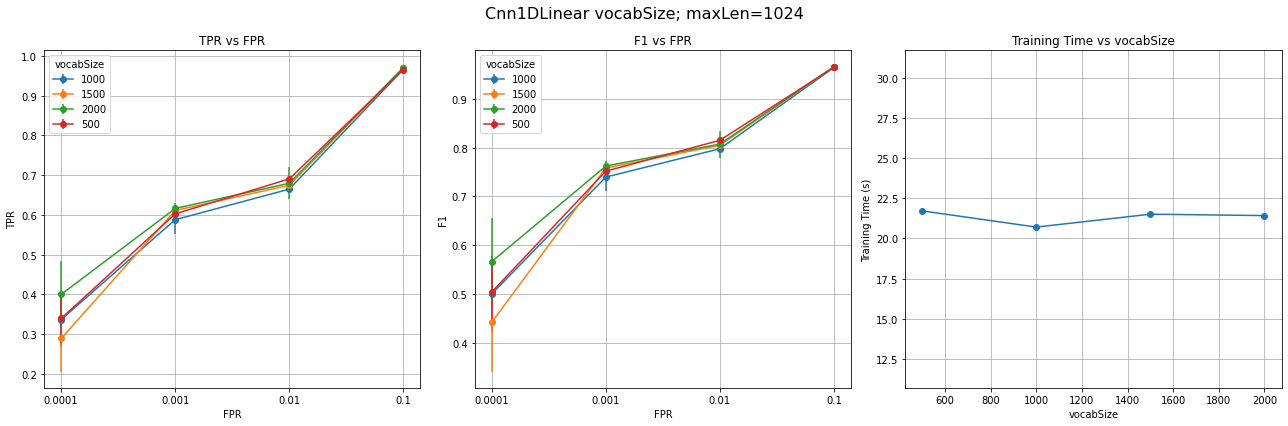

In [145]:
folder = "Cnn1DLinear_VocabSize_maxLen"
field = "vocabSize"
diffExtractor = lambda x: x.split(field)[1].split("_")[1]

myFilter = "maxLen_1024_"
extraFileFilter = lambda x: myFilter in x

title = f"{folder.split('_')[0]} {field}; {'='.join(myFilter.split('_')[:-1])}"
pngPath = title.replace(" ", "_").replace("=", "_").replace(";", "")+".png"
plotFolder(folder, field, diffExtractor, extraFileFilter, title=title, savePath=pngPath)

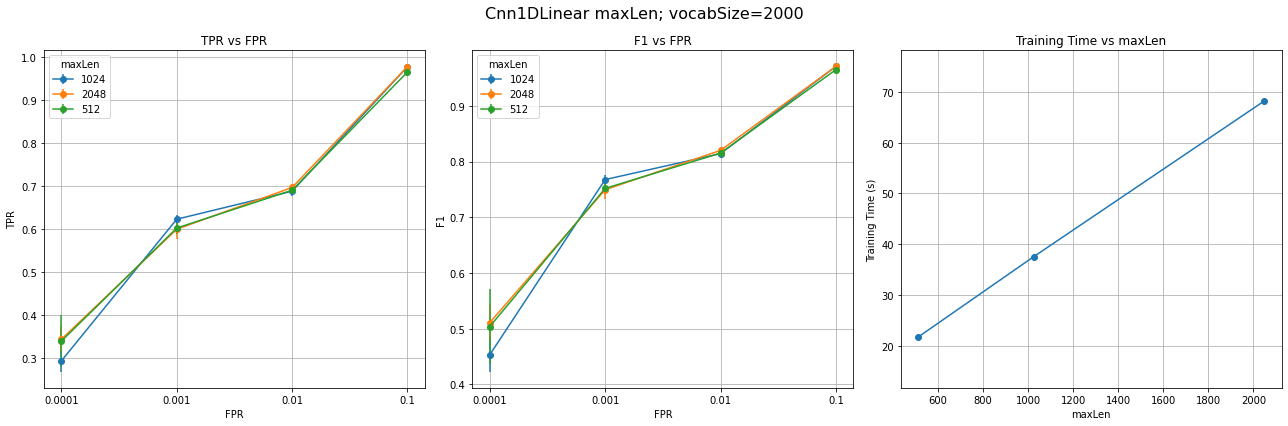

In [146]:
folder = "Cnn1DLinear_VocabSize_maxLen"
field = "maxLen"
diffExtractor = lambda x: x.split(field)[1].split("_")[1]

myFilter = "vocabSize_2000_"
extraFileFilter = lambda x: myFilter in x

title = f"{folder.split('_')[0]} {field}; {'='.join(myFilter.split('_')[:-1])}"
pngPath = title.replace(" ", "_").replace("=", "_").replace(";", "")+".png"
plotFolder(folder, field, diffExtractor, extraFileFilter, title=title, savePath=pngPath)

### Plot heatmap of maxLen and vocabSize